**Sources:**

[Orbit’s Documentation](https://orbit-ml.readthedocs.io/en/latest/tutorials/dlt.html#)

[GitHub Repository](https://github.com/uber/orbit)

NBP report on CPI prognosis: https://nbp.pl/projekcja-inflacji-i-pkb-lipiec-2022/

---

# Import libraries

In [118]:
import pandas as pd
import numpy as np
from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data

# Load data

Data source: https://bdm.stat.gov.pl/

In [81]:
# Import the price index data from a csv file
data = pd.read_csv('../data/price_index_monthly.csv', sep=";")

# Rename the columns for clarity and filter the data for specific index and unit
data = (
    data
    .rename(columns={data.columns[0]: "index", data.columns[1]: "second_column", data.columns[2]: "unit"})
    .query('index == "Wskaźniki cen towarów i usług konsumpcyjnych"')
    .query('unit == "analogiczny okres roku poprzedniego=100"')
)

# Select the first row and reset index
data = (
    data
    .iloc[0]
    .reset_index()
    .rename(columns={"index": "date", 36: "price_index"})
    .query("date != 'index' and date != 'second_column' and date != 'unit'")
)

# Replace comma with dot in price index and convert string to float
data = (
    data
    .apply(lambda x: x.str.replace(',', '.') if x.name == 'price_index' else x)
    .astype({'date': str, 'price_index': float})
)

# Calculate the price index and adjust the date format
data = (
    data
    .assign(price_index=lambda x: (x['price_index'] - 100))
    .assign(date=lambda x: np.where(x['date'].str.len() == 4, x['date'] + '.0', x['date']))
)

# Extract year and month from the date and recreate the date
data = (
    data
    .assign(year=lambda x: x['date'].str.split('.').str[0].astype(int))
    .assign(month=lambda x: x['date'].str.split('.').str[1].astype(int) + 1)
    .assign(date=lambda x: x['year'].astype(str) + "." + x['month'].astype(str))
)

# Drop the redundant columns
data = data.drop(['year', 'month'], axis=1)

# Convert the date to datetime format
data = (
    data
    .assign(date=lambda x: pd.to_datetime(x['date'], format='%Y.%m'))
)

# Append new data and set date as index, then sort by index
data = (
    data
    .append(pd.DataFrame({'date':pd.to_datetime("2023.05", format='%Y.%m'), 'price_index':13}, index=[0]))
    .set_index("date", drop=False)
    .sort_index()
)

data

/tmp/ipykernel_52798/3114557615.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data


,date,price_index
date,,
2000-01-01,2000-01-01,10.1
2000-02-01,2000-02-01,10.4
2000-03-01,2000-03-01,10.3
2000-04-01,2000-04-01,9.8
2000-05-01,2000-05-01,10.0
...,...,...
2023-01-01,2023-01-01,16.6
2023-02-01,2023-02-01,18.4
2023-03-01,2023-03-01,16.1


Below, is the plot of price index data

<AxesSubplot:xlabel='date'>

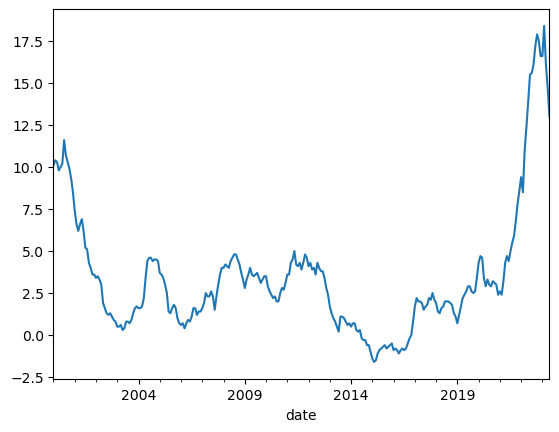

In [62]:
data.price_index.plot()

# Damped Local Trend Model

The Damped Local Trend (DLT) model is an instance of the state-space models that are widely used in time series analysis and forecasting. It originates from the class of Exponential Smoothing Models, more specifically the Holt's linear exponential smoothing method, and is extended with Bayesian methods for inference and prediction.

The DLT model has two main components: the local level and the local trend. The local level captures the current value of the series, while the local trend captures the change in the level from one time period to the next. The DLT model "dampens" this trend over time to account for potential changes in trend direction, hence the name "Damped Local Trend".

In mathematical terms, a DLT model can be formulated as follows:

Observation equation (local level):

y[t] = µ[t] + ε[t],

where y[t] is the observation at time t, µ[t] is the local level, and ε[t] is the observation error.

State equation (local trend):

µ[t] = µ[t-1] + b[t-1] * φ + η[t],

b[t] = b[t-1] * φ + ξ[t],

where b[t] is the local trend, φ is the damping factor (0 < φ < 1), and η[t] and ξ[t] are state errors.

The term 'damping' refers to the process of making the trend component decrease over time, by multiplying it with the damping factor φ.

In Bayesian context, priors can be specified for the parameters of the DLT model. The model is then estimated using Bayesian methods, such as Markov Chain Monte Carlo (MCMC), to provide posterior distributions for the parameters.

The DLT model is particularly useful for handling time series with non-stationary or changing trends. By dampening the local trend component, the model can become more robust to sudden shifts or reversals in the trend direction, making it suitable for forecasting in uncertain and changing environments.

In terms of applications, DLT models have been used in diverse areas such as economics, finance, and supply chain management, for tasks such as demand forecasting, stock market prediction, and macroeconomic forecasting.

In [91]:
# Create a date range starting from the last date in 'data' and ending at 2024-12-01
new_dates = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1),
                          end='2024-12-01', freq='MS')

# Create a new DataFrame with the generated dates as the index and a column named 'date'
new_df = pd.DataFrame(index=new_dates, columns=['date'])

# Assign the index values (dates) to the 'date' column
new_df['date'] = new_df.index

# Concatenate the existing 'data' DataFrame with the newly created DataFrame
data = pd.concat([data, new_df])

2023-06-20 01:24:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

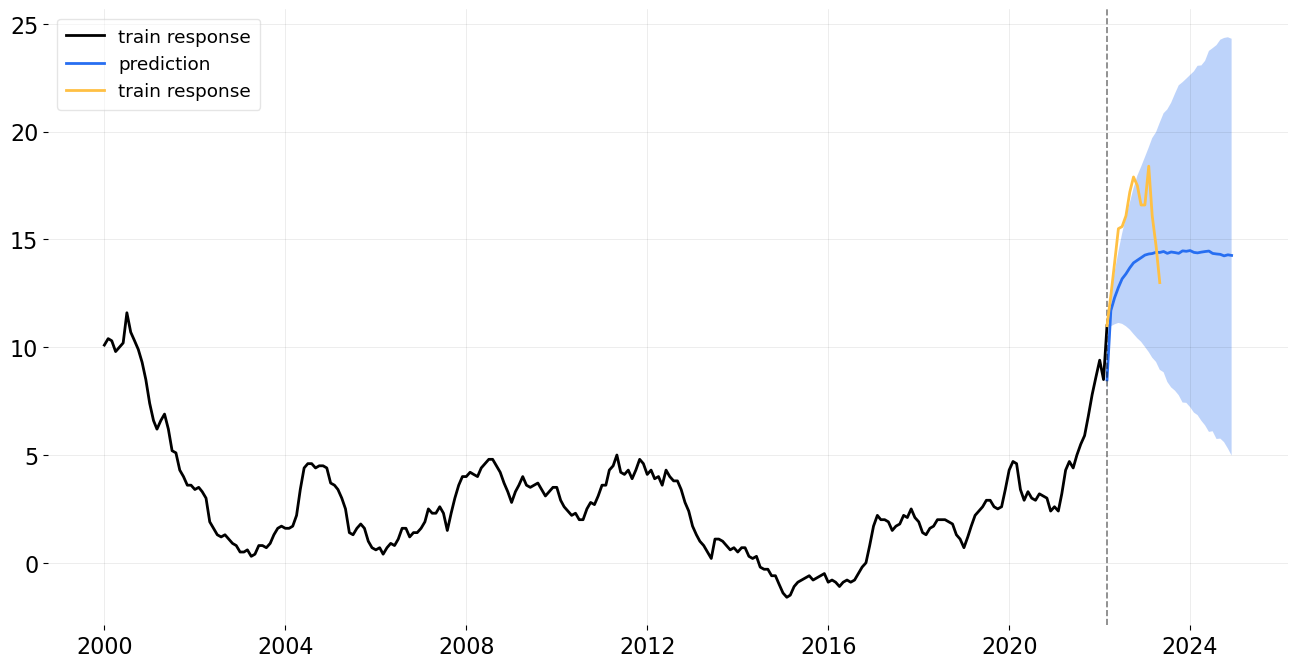

<AxesSubplot:>

In [112]:
# Define the training period as a dictionary with start and end dates
train_period_dict = {
    "train_start": "2000-01-01",
    "train_end": "2022-03-01"
}

# Define the testing period as a dictionary with start and end dates
test_period_dict = {
    "test_start": "2022-03-01",
    "test_end": "2024-12-01"
}

# Using the train_period_dict, slice the original 'data' DataFrame to obtain the training data
train_df = data.loc[train_period_dict["train_start"]:train_period_dict["train_end"]]

# Similarly, use the test_period_dict to obtain the testing data
test_df = data.loc[test_period_dict["test_start"]:test_period_dict["test_end"]]

# Initialize an instance of the DLT (Dampend Local Trend) model with specified parameters
# 'response_col' is the column in the DataFrame we want to predict
# 'date_col' is the column in the DataFrame that contains the dates
# 'estimator' is the method we want to use for estimation, here we use MCMC
# 'seasonality' is set to 0, indicating no seasonality
# 'global_trend_option' is set to 'flat', indicating we expect the global trend to be relatively constant. Usually with CPI we expect/want it to remain relatively constant at a given target value.
# 'n_bootstrap_draws' is set to 1000, which is the number of bootstrap samples to draw for uncertainty estimation
dlt = DLT(
    response_col='price_index',
    date_col='date',
    estimator='stan-mcmc',
    seasonality=0,
    global_trend_option='flat',
    n_bootstrap_draws=1000
)

# Fit the DLT model to the training data
dlt.fit(df=train_df)

# outcomes data frame
predicted_df = dlt.predict(df=test_df)

#plot the data and the predictions
plot_predicted_data(
    training_actual_df=train_df, predicted_df=predicted_df,
    date_col=dlt.date_col, actual_col=dlt.response_col,
    test_actual_df=test_df,
    line_plot=True
)

Below, we zoom in the plot above to show the same period as in NBP presentation: from 2019-01-01 to 2024-12-01.

The main difference is that we are dealing with monthly data, while NBP takes quarterly data.

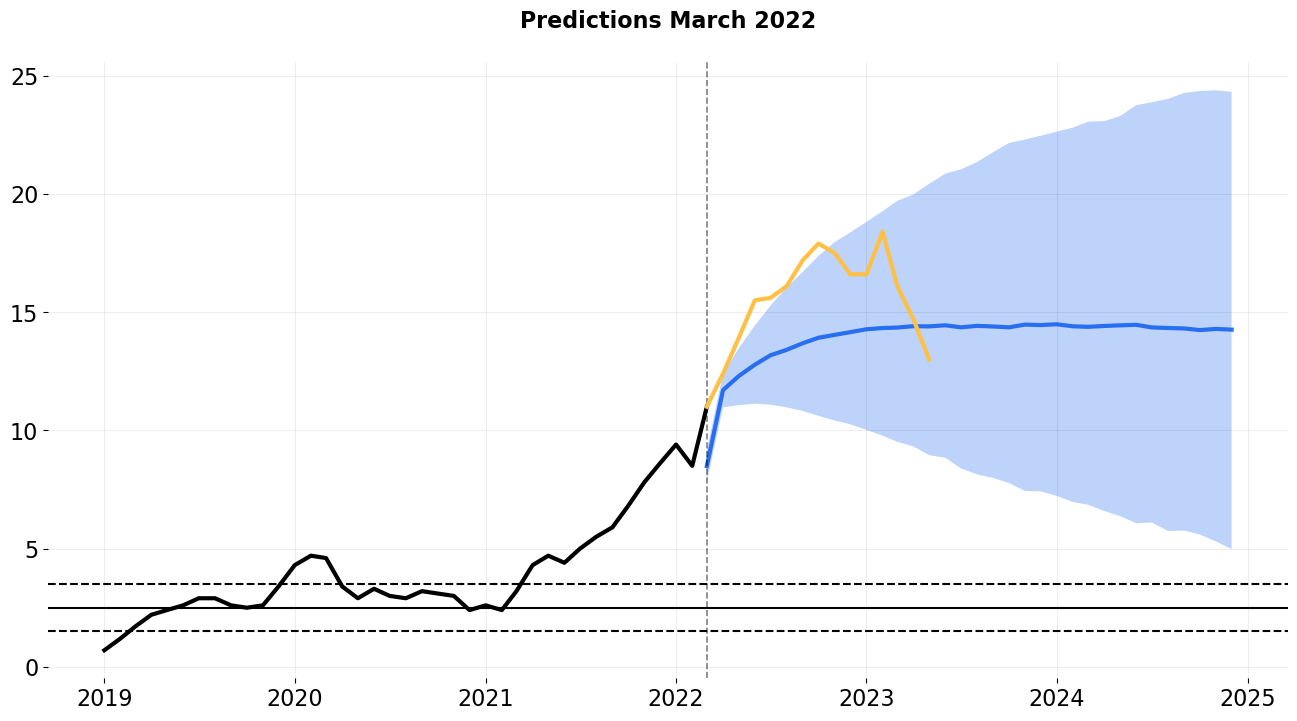

In [127]:
ax = plot_predicted_data(
    training_actual_df=train_df.loc["2019-01-01":], predicted_df=predicted_df,
    date_col=dlt.date_col, actual_col=dlt.response_col,
    test_actual_df=test_df,
    is_visible = False,
    line_plot=True,
    markersize=50,
    lw=3,
    linestyle="-",
    title = "Predictions March 2022"
)

ax.axhline(y=3.5, linestyle='--', color='black')
ax.axhline(y=2.5, linestyle='-', color='black')
ax.axhline(y=1.5, linestyle='--', color='black')
ax.legend().set_visible(False)

ax.figure

Below is the CPI prognosis from NBP for 12.07.2022:

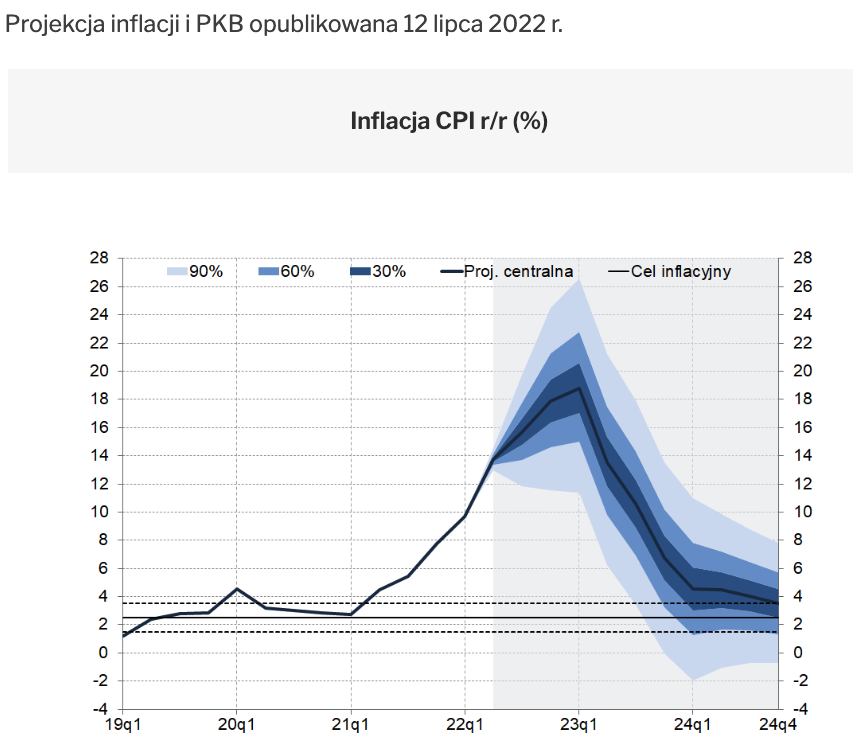

For the whole testing period, observations do not fall outside confidence interval (almost). However, we do not observe the same steep decline in inflation rate as NBP did, as seen in the report found above. Instead we observe that the predictions stabilizes around 15%, which probably will not be the case, as it is likely that some policies will be undertaken to chagne the level, aiming for the 2.5% target that NBP has. The model constructed here seems to be much more stable in its prediction, which might not be great here, as clearly inflation is highly volitile for the predicted period. To improve we could introduce more variables, such as other covariates or more lags.